# Topic Modelling

In [ ]:
# include notebooks dataset processing cordis & nsf

## 0. Libraries

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Lemmatization
import spacy

# Vectorization
import gensim

# Topic modelling
from gensim.models.wrappers import LdaMallet
from customMallet import CustomMallet
mallet_path = '/Users/celiaromerogonzalez/Mallet/bin/mallet'
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel

# Document LDA representation
import pyLDAvis.gensim as gensimvis
import pyLDAvis

import warnings
warnings.filterwarnings('ignore')

## 1. Creating dataframe

Read CSVs corresponding to Cordis and NSF datasets. Only the columns of interest are imported.

### 1.1 Cordis dataset

In [2]:
cordis = pd.read_csv("data/cordis/cordis.csv",usecols=['id','objective'])

print('Cordis null abstracts: %d (%.4f %%)' % (cordis['objective'].isnull().sum(),cordis['objective'].isnull().sum()/cordis.shape[0]))
print('Cordis shape with null abstracts: ',cordis.shape)
cordis = cordis[cordis['objective'].notna()]
print('Cordis shape without null abstracts: ',cordis.shape)
cordis['objective'].isnull().sum()

Cordis null abstracts: 157 (0.0023 %)
Cordis shape with null abstracts:  (67703, 2)
Cordis shape without null abstracts:  (67546, 2)


0

### 1.2 NSF dataset

In [3]:
nsf = pd.read_csv('data/nsf/nsf.csv',usecols=['AwardID','AbstractNarration'])
nsf = nsf.drop_duplicates()
print('NSF null abstracts: %d (%.4f %%)' % (nsf['AbstractNarration'].isnull().sum(),nsf['AbstractNarration'].isnull().sum()/nsf.shape[0]))
print('NSF shape with null abstracts: ',nsf.shape)
nsf = nsf[nsf['AbstractNarration'].notna()]
print('NSF shape without null abstracts: ',nsf.shape)
nsf['AbstractNarration'].isnull().sum()

NSF null abstracts: 2619 (0.0114 %)
NSF shape with null abstracts:  (229499, 2)
NSF shape without null abstracts:  (226880, 2)


0

### 1.3 Join dataframes

In [4]:
# Add column with source of documents
cordis['org'] = 'EU'
nsf['org'] = 'NSF'

# Rename columns to match headers later
cordis = cordis.rename(columns={'objective':'abstract'})
nsf = nsf.rename(columns={'AwardID':'id','AbstractNarration':'abstract'})

# Join dataframes into 1
corpusdata = cordis.append(nsf)
corpusdata

,id,abstract,org
0,672890,'The project targets all luxury fashion firms ...,EU
1,633814,EU's agricultural and forestry land provides a...,EU
2,785419,"According to the Global Market Forecast, there...",EU
3,721362,In the aerospace industry very high quality st...,EU
4,861924,Large areas of agricultural land in W. and N. ...,EU
...,...,...,...
345996,1.61448e+06,A few micro-seconds after the Big Bang the uni...,NSF
345997,1.62455e+06,Calcium sulfate in crystalline form (anhydrite...,NSF
345998,1.6047e+06,The Rocky Mountain-Great Plains Graduate Resea...,NSF
345999,1.65392e+06,Investments made across national boundaries cr...,NSF


In [5]:
corpusdata.org.value_counts()

NSF    226880
EU      67546
Name: org, dtype: int64

## 2. Lemmatization with Spacy

... explain ...

### 2.1 Lemmatize

In [6]:
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])

def text_preprocessing(rawtext):
    lemmatized = ' '.join([token.lemma_ for token in doc 
                           if token.is_alpha
                           and token.pos_ in valid_POS
                           and not token.is_stop])
    return lemmatized


corpusdata['lemmas'] = None

for i in range(len(corpusdata)):
    if not i%10000:
        print('Preprocessing abstract %d out of %d' % (i,len(corpusdata['abstract'])))
    doc = nlp(corpusdata['abstract'].iloc[i])
    corpusdata['lemmas'].iloc[i] = text_preprocessing(doc)

corpusdata.to_csv('data/corpusdata_lemmatized.csv',sep=';',index=False)

corpusdata

"""

# OR

corpusdata = pd.read_csv('data/corpusdata_lemmatized.csv',sep=';')
corpusdata

"""

Preprocessing abstract 0 out of 294426
Preprocessing abstract 10000 out of 294426
Preprocessing abstract 20000 out of 294426
Preprocessing abstract 30000 out of 294426
Preprocessing abstract 40000 out of 294426
Preprocessing abstract 50000 out of 294426
Preprocessing abstract 60000 out of 294426
Preprocessing abstract 70000 out of 294426
Preprocessing abstract 80000 out of 294426
Preprocessing abstract 90000 out of 294426
Preprocessing abstract 100000 out of 294426
Preprocessing abstract 110000 out of 294426
Preprocessing abstract 120000 out of 294426
Preprocessing abstract 130000 out of 294426
Preprocessing abstract 140000 out of 294426
Preprocessing abstract 150000 out of 294426
Preprocessing abstract 160000 out of 294426
Preprocessing abstract 170000 out of 294426
Preprocessing abstract 180000 out of 294426
Preprocessing abstract 190000 out of 294426
Preprocessing abstract 200000 out of 294426
Preprocessing abstract 210000 out of 294426
Preprocessing abstract 220000 out of 294426
Pr

"\n\n# OR\n\ncorpusdata = pd.read_csv('data/corpusdata_lemmatized.csv',sep=';')\ncorpusdata\n\n"

### 2.2 Count lemmas

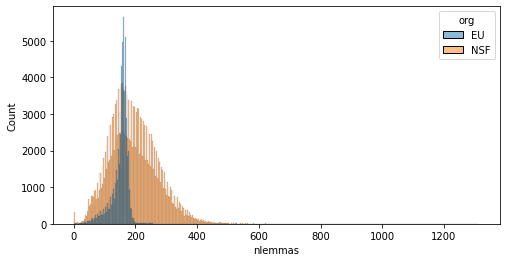

In [7]:
def count_lemmas(x):
    return len(x.split())

corpusdata = corpusdata[corpusdata['lemmas'].notna()]
corpusdata['lemmas'] = corpusdata['lemmas'].str.lower()
corpusdata['nlemmas'] = corpusdata['lemmas'].apply(count_lemmas)
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
sns.histplot(data = corpusdata, x='nlemmas', hue='org')
plt.show()

### 2.3 Remove documents with few lemmas

proportions in both datasets are similar

In [11]:
print('EU >= 100: ',len(corpusdata[(corpusdata['org']=='EU') & (corpusdata['nlemmas']>=100)]))
print('EU < 100: ',len(corpusdata[(corpusdata['org']=='EU') & (corpusdata['nlemmas']<100)]))

EU >= 100:  62959
EU < 100:  4587


In [12]:
print('NSF >= 100: ',len(corpusdata[(corpusdata['org']=='NSF') & (corpusdata['nlemmas']>=100)]))
print('NSF < 100: ',len(corpusdata[(corpusdata['org']=='NSF') & (corpusdata['nlemmas']<100)]))

NSF >= 100:  205702
NSF < 100:  21178


In [13]:
corpusdata = corpusdata[corpusdata['nlemmas']>=100]
print('Number of projects after removing short abstracts:', len(corpusdata))

Number of projects after removing short abstracts: 268661


## 3. Vectorization with Gensim

### 3.1 Dictionary

In [14]:
corpuslemmas = corpusdata.lemmas.tolist()
corpuslemmas = list(set(corpuslemmas)) # project order lost at this point
corpuslemmas = [el.split() for el in corpuslemmas]

# Create dictionary of tokens
D = gensim.corpora.Dictionary(corpuslemmas)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 238302 terms
First terms in the dictionary:
0 : accelerate
1 : activity
2 : address
3 : adsorption
4 : alkene
5 : ambient
6 : anticipate
7 : appointment
8 : aquaculture
9 : area


#### 3.1.1 Filter extremes in dictionary

In [15]:
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

# D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
D.filter_extremes(no_below=no_below,no_above=no_above) # keep all
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 57257 terms
First terms in the dictionary:
0 : accelerate
1 : activity
2 : address
3 : adsorption
4 : alkene
5 : ambient
6 : anticipate
7 : appointment
8 : aquaculture
9 : area


### 3.2 Create bag of words

In [16]:
corpusbow = [D.doc2bow(doc) for doc in corpuslemmas]

## 4. Topic modelling with Mallet

### 4.1 Initial topic model

20 topics

In [ ]:
ldamallet = LdaMallet(mallet_path, corpus=corpusbow, num_topics=20, id2word=D, alpha=5, iterations=100)

In [ ]:
topn = 25 # top 25 words in each topic

fig, axes = plt.subplots(4, 5, figsize=(16, 20), sharex=True)

for i in range(5):

    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldamallet.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 5
    df = pd.DataFrame(ldamallet.show_topic(i+5, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 10
    df = pd.DataFrame(ldamallet.show_topic(i+10, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[2][i])
    axes[2][i].set_title('Topic ' + str(i+10))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 15
    df = pd.DataFrame(ldamallet.show_topic(i + 15, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[3][i])
    axes[3][i].set_title('Topic ' + str(i + 15))
    
plt.show()

In [ ]:
mytopics20 = pd.DataFrame(columns=['topic','word'])

for i in range(len(ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False))):
    for j in range(len(ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][1])):
        new_row = {'topic':ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][0],
                   'word':ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][1][j][0]}
        mytopics20 = mytopics20.append(new_row,ignore_index=True)
        
mytopics20.to_excel('data/mytopics20.xlsx',index=False)

### 4.2 Cleaning vocabulary

In [17]:
specific_stw = ['activity','aim','analysis','application','approach','area','attend','award',
                'base','bring','broad',
                'center','challenge','change','collaboration','collaborative','collection','community','complex','concept','condition','conference','content','context','cost','create','current',
                'data','datum','deem','design','development','discuss','discussion',
                'effect','enable','engineering','establish','eu','evaluation','examine','experience',
                'field','focus','foundation','formation','framework','function','fundamental',
                'goal','group',
                'hold','human',
                'identify','important','improve','increase','information','innovation','intellectual','interaction','international','issue',
                'key','knowledge',
                'large','learn','learning','long','low',
                'main','management','material','mechanism','merit','meeting','method','middle','mission','model','modeling',
                'national','network','nsf','number',
                'objective','open','opportunity','outreach',
                'participant','participant','participation','performance','phase','potential','practice','present','presentation','problem','process','professional','programme','program','property','propose','public',
                'question',
                'real','reduce','reflect','researcher','resolution','response','result','review','role',
                'scale','science','scientist','scientific','service','session','small','solution','solve','specific','state','structure',
                'target','team','technique','technology','test','theory','time','tool','topic','type',
                'underrepresented','understand','understanding','university',
                'week','work','workshop','worthy',
                'year']

In [18]:
# count how many stopwords appear in each document
def count_stopwords(doc):
    stws = doc.lower().split()
    stws = [sw for sw in stws if sw in specific_stw]
    return len(stws)

corpusdata['nstopwords'] = corpusdata['lemmas'].apply(count_stopwords)
corpusdata

,id,abstract,org,lemmas,nlemmas,nstopwords
0,672890,'The project targets all luxury fashion firms ...,EU,project target luxury fashion firm manufacture...,152,33
1,633814,EU's agricultural and forestry land provides a...,EU,eu agricultural forestry land provide wide ran...,176,35
2,785419,"According to the Global Market Forecast, there...",EU,accord global market forecast strong need ramp...,167,35
3,721362,In the aerospace industry very high quality st...,EU,aerospace industry high quality standard meet ...,149,23
4,861924,Large areas of agricultural land in W. and N. ...,EU,large area agricultural land africa degrade wa...,188,32
...,...,...,...,...,...,...
345996,1.61448e+06,A few micro-seconds after the Big Bang the uni...,NSF,micro second big bang universe fill hot plasma...,206,30
345997,1.62455e+06,Calcium sulfate in crystalline form (anhydrite...,NSF,calcium sulfate crystalline form anhydrite mel...,284,25
345998,1.6047e+06,The Rocky Mountain-Great Plains Graduate Resea...,NSF,rocky mountain great plains graduate research ...,179,59
345999,1.65392e+06,Investments made across national boundaries cr...,NSF,investment national boundary create internatio...,164,29


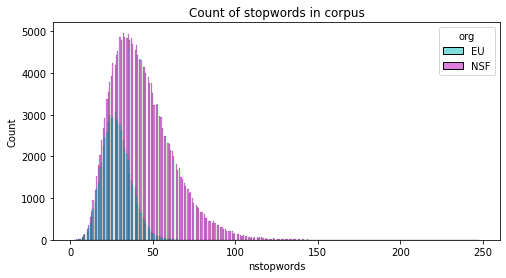

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
sns.histplot(data = corpusdata, x='nstopwords', hue='org', palette=['c','m'])
plt.title('Count of stopwords in corpus')
plt.show()

In [20]:
def clean_lemmas(orig_str):
    lemmas = orig_str.lower().split()
    lemmas = [el for el in lemmas if el not in specific_stw]
    return ' '.join(lemmas)

corpusdata['clean_lemmas'] = corpusdata['lemmas'].apply(clean_lemmas)
corpusdata

,id,abstract,org,lemmas,nlemmas,nstopwords,clean_lemmas
0,672890,'The project targets all luxury fashion firms ...,EU,project target luxury fashion firm manufacture...,152,33,project luxury fashion firm manufacture classi...
1,633814,EU's agricultural and forestry land provides a...,EU,eu agricultural forestry land provide wide ran...,176,35,agricultural forestry land provide wide range ...
2,785419,"According to the Global Market Forecast, there...",EU,accord global market forecast strong need ramp...,167,35,accord global market forecast strong need ramp...
3,721362,In the aerospace industry very high quality st...,EU,aerospace industry high quality standard meet ...,149,23,aerospace industry high quality standard meet ...
4,861924,Large areas of agricultural land in W. and N. ...,EU,large area agricultural land africa degrade wa...,188,32,agricultural land africa degrade water scarcit...
...,...,...,...,...,...,...,...
345996,1.61448e+06,A few micro-seconds after the Big Bang the uni...,NSF,micro second big bang universe fill hot plasma...,206,30,micro second big bang universe fill hot plasma...
345997,1.62455e+06,Calcium sulfate in crystalline form (anhydrite...,NSF,calcium sulfate crystalline form anhydrite mel...,284,25,calcium sulfate crystalline form anhydrite mel...
345998,1.6047e+06,The Rocky Mountain-Great Plains Graduate Resea...,NSF,rocky mountain great plains graduate research ...,179,59,rocky mountain great plains graduate research ...
345999,1.65392e+06,Investments made across national boundaries cr...,NSF,investment national boundary create internatio...,164,29,investment boundary flow capital flow help det...


#### 4.2.1 Remove again documents with few lemmas

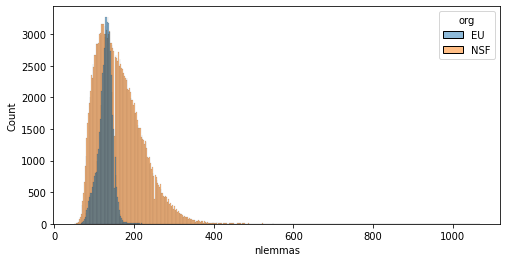

In [21]:
# filter again according to the number of lemmas
corpusdata['nlemmas'] = corpusdata['clean_lemmas'].apply(count_lemmas)
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
sns.histplot(data = corpusdata, x='nlemmas', hue='org')
plt.show()

In [22]:
print('There are ',len(corpusdata[corpusdata['nlemmas']<100]),' short documents.')
corpusdata = corpusdata[corpusdata['nlemmas']>=100]
print('Number of projects after applying specific stopwords and removing short texts:', len(corpusdata))

There are  28039  short documents.
Number of projects after applying specific stopwords and removing short texts: 240622


#### 4.2.2 Create dictionary again

In [23]:
mycorpus = corpusdata.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) # project order lost at this point
mycorpus = [el.split() for el in mycorpus]

# Create dictionary of tokens
D = gensim.corpora.Dictionary(mycorpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

    
print('\nFiltering extremes...\n')
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

#D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
D.filter_extremes(no_below=no_below,no_above=no_above) # keep all
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 228925 terms
First terms in the dictionary:
0 : achieve
1 : act
2 : additional
3 : advance
4 : american
5 : arra
6 : assess
7 : attempt
8 : available
9 : build

Filtering extremes...

The dictionary contains 54868 terms
First terms in the dictionary:
0 : achieve
1 : act
2 : additional
3 : advance
4 : american
5 : arra
6 : assess
7 : attempt
8 : available
9 : build


In [24]:
corpusdata.to_csv('data/corpusdata_clean.csv',sep=';',index=False)
D.save('data/clean_gensim.dict')

In [2]:
corpusdata = pd.read_csv('data/corpusdata_clean.csv',sep=';')
D = gensim.corpora.Dictionary.load('data/clean_gensim.dict')

#### 4.2.3 Create again bag of words

In [3]:
mycorpus = corpusdata.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) # at this point project order is lost
mycorpus = [el.split() for el in mycorpus]
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

### 4.3 Validating number of topics using coherence

#### 4.3.1 First round with wide range

Estimating coherence for a model with 5 topics
[0.5577567447423453]
Estimating coherence for a model with 10 topics
[0.5577567447423453, 0.6214206113807091]
Estimating coherence for a model with 15 topics
[0.5577567447423453, 0.6214206113807091, 0.6540179474218328]
Estimating coherence for a model with 20 topics
[0.5577567447423453, 0.6214206113807091, 0.6540179474218328, 0.6612540862854239]
Estimating coherence for a model with 25 topics
[0.5577567447423453, 0.6214206113807091, 0.6540179474218328, 0.6612540862854239, 0.6694970252000513]
Estimating coherence for a model with 35 topics
[0.5577567447423453, 0.6214206113807091, 0.6540179474218328, 0.6612540862854239, 0.6694970252000513, 0.6639323282096738]
Estimating coherence for a model with 50 topics
[0.5577567447423453, 0.6214206113807091, 0.6540179474218328, 0.6612540862854239, 0.6694970252000513, 0.6639323282096738, 0.6631434080291772]
Estimating coherence for a model with 75 topics
[0.5577567447423453, 0.6214206113807091, 0.6540179

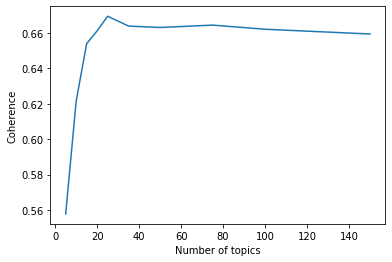

Maximum coherence (0.669497) is achieved with 25 topics


In [27]:
n_topics = [5, 10, 15, 20, 25, 35, 50, 75, 100, 150]

tc = []
for ntpc in n_topics:
    print('Estimating coherence for a model with', ntpc, 'topics')
    lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=250)
    ldagensim = malletmodel2ldamodel(lda_ntpc)
    tc.append(CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v').get_coherence())
    print(tc)
    
plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.show()

print('Maximum coherence (%f) is achieved with %d topics' % (max(tc),n_topics[tc.index(max(tc))]))

In [28]:
tcfile = open("data/tc1.txt","w")
tcfile.write(str((tc)))
tcfile.close()

#### 4.3.2 Round with several iterations to obtain mean and standard deviation

Estimating coherence for a model with 5 topics
[0.50386717 0.56440651 0.53794903 0.52151818 0.5597395 ]
Estimating coherence for a model with 10 topics
[0.62665852 0.59709163 0.62265009 0.63198819 0.63434147]
Estimating coherence for a model with 15 topics
[0.65992451 0.65389386 0.63209306 0.65203389 0.64350092]
Estimating coherence for a model with 20 topics
[0.66200084 0.64784588 0.66271947 0.65609846 0.66223759]
Estimating coherence for a model with 25 topics
[0.66705421 0.65653115 0.66308872 0.66158953 0.67688876]
Estimating coherence for a model with 35 topics
[0.67459986 0.66803821 0.66478886 0.66648183 0.66742247]
Estimating coherence for a model with 50 topics
[0.66185202 0.67009702 0.66710565 0.66202286 0.66749992]
Estimating coherence for a model with 75 topics
[0.66390732 0.65942832 0.66247711 0.67018978 0.65925687]
Estimating coherence for a model with 100 topics
[0.6641495  0.65596733 0.66145025 0.656922   0.66855553]


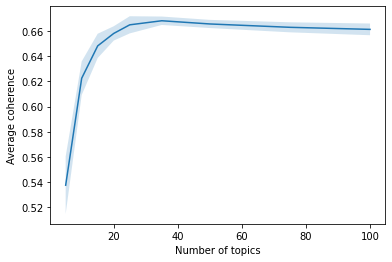

Maximum mean coherence (0.668266) is achieved with 35 topics


In [25]:
#n_topics = [5, 10, 15, 20, 25, 35, 50, 75, 100, 150]
n_topics = [5, 10, 15, 20, 25, 35, 50, 75, 100]
iterations = 5 #10, 20...
tc = pd.DataFrame(columns=['ntpcs','mean','sd'])

for ntpc in n_topics:
    print('Estimating coherence for a model with', ntpc, 'topics')
    coherences = np.array([])
    for i in range(iterations):
        lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=250)
        #lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=100)
        ldagensim = malletmodel2ldamodel(lda_ntpc)
        coherence = CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v').get_coherence()
        coherences = np.append(coherences,coherence)
    print(coherences)
    tc.loc[n_topics.index(ntpc)] = [ntpc,np.mean(coherences),np.std(coherences)]

tc.to_csv('data/tc.csv',sep=';',index=False)


plt.plot(n_topics, tc['mean'])
plt.fill_between(n_topics,tc['mean']-tc['sd'],tc['mean']+tc['sd'],alpha=0.2)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')
plt.show()

print('Maximum mean coherence (%f) is achieved with %d topics' % (tc['mean'].max(),n_topics[tc['mean'].idxmax()]))

### 4.4 Document LDA representation

In [ ]:
#mycorpus = pd.read_excel('corpusdata_clean_2.xlsx')
#mycorpus_bow = gensim.corpora.Dictionary.load('clean_gensim_2.dict')

#mycorpus = pd.read_excel('corpusdata_clean_3.xlsx')
#mycorpus_bow = gensim.corpora.Dictionary.load('clean_gensim_3.dict')

In [26]:
ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=35, id2word=D, alpha=5, iterations=1000)

In [27]:
mytopics = pd.DataFrame(columns=['topic','word'])
topn = 35

for i in range(len(ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False))):
    for j in range(len(ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][1])):
        new_row = {'topic':ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][0],
                   'word':ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][1][j][0]}
        mytopics = mytopics.append(new_row,ignore_index=True)
        
mytopics.to_excel('data/mytopics35.xlsx',index=False)

In [28]:
ldagensim = malletmodel2ldamodel(ldamallet)
vis_data = gensimvis.prepare(ldagensim, mycorpus_bow, D)
pyLDAvis.display(vis_data)

In [30]:
tpc_descriptions = []

for ntpc in range(35):
    print(ldagensim.show_topic(ntpc, topn=20))
    desc = input('Introduce a label for topic ' + str(ntpc) + ': ')
    tpc_descriptions.append(desc)

[('chemistry', 0.03313687385661268), ('chemical', 0.031193542581281597), ('reaction', 0.024120773596210846), ('metal', 0.016637922982113605), ('organic', 0.015816620608424443), ('molecule', 0.014457655654456107), ('synthesis', 0.01307704750340026), ('catalyst', 0.012636209752196785), ('molecular', 0.01128977507022648), ('compound', 0.008744990738989877), ('professor', 0.008542228155749003), ('carbon', 0.006545358445517238), ('catalytic', 0.006035034640506497), ('bond', 0.005636344167841855), ('hydrogen', 0.005550910495128002), ('catalysis', 0.0054461118565990105), ('synthetic', 0.0051715849882785), ('ion', 0.005168167641369946), ('division', 0.005108933628288342), ('undergraduate', 0.005074760159202801)]


Introduce a label for topic 0:  Chemistry


[('market', 0.03438476324399109), ('product', 0.02367730192840902), ('industry', 0.0226748240844168), ('business', 0.020688012791798733), ('manufacturing', 0.015520262186513045), ('company', 0.013281697408186525), ('commercial', 0.012549117445269133), ('production', 0.010177871775825995), ('industrial', 0.008331679547297336), ('customer', 0.006570539172048559), ('sector', 0.006426518033827957), ('quality', 0.006207651264721058), ('platform', 0.005933217284804636), ('innovative', 0.005506823993694823), ('sbir', 0.005193833173624853), ('chain', 0.005058884233087439), ('demand', 0.004957956033861978), ('user', 0.004801460623826993), ('consumer', 0.004726614992940696), ('supply', 0.004589398002982485)]


Introduce a label for topic 1:  Business Management


[('european', 0.029883067920937298), ('europe', 0.014913770489919946), ('partner', 0.011475886947147927), ('training', 0.010170046470305534), ('consortium', 0.008027472432788469), ('country', 0.007823554528413521), ('expertise', 0.007685694536723414), ('innovative', 0.006377939337774213), ('action', 0.006022758386961509), ('level', 0.005749910486741508), ('skill', 0.005590031190823121), ('industry', 0.005559395637114209), ('future', 0.00548089203073512), ('centre', 0.0053602645380062776), ('sme', 0.005092203443053294), ('lead', 0.0049763627555914685), ('sector', 0.004795421516498204), ('stakeholder', 0.0047628712406824845), ('implementation', 0.004637456942686624), ('achieve', 0.004524488338385009)]


Introduce a label for topic 2:  Other


[('earth', 0.021212613784135245), ('mantle', 0.011340166755909127), ('rock', 0.01118239883729825), ('mineral', 0.01018320201942936), ('isotope', 0.010117863790509704), ('composition', 0.007246168948723834), ('sample', 0.006972067110329178), ('temperature', 0.006929039496162575), ('core', 0.006662905734465438), ('volcanic', 0.006632627043014866), ('record', 0.006342589051225173), ('evolution', 0.0063091231290955925), ('element', 0.006156136056503226), ('magma', 0.005912312909559143), ('history', 0.0055059409979856715), ('deep', 0.005461319768479565), ('eruption', 0.00530514546520819), ('isotopic', 0.0052908029271526566), ('determine', 0.005136222239220787), ('crust', 0.005067696779622123)]


Introduce a label for topic 3:  Geology


[('gene', 0.042390338378910965), ('plant', 0.03142538373115153), ('genetic', 0.020822667426562212), ('genome', 0.017380195705302203), ('dna', 0.01401741641953962), ('expression', 0.013465606676777141), ('sequence', 0.013422138075596727), ('molecular', 0.009855297856514978), ('rna', 0.009516001275078968), ('cell', 0.009123576403311342), ('genomic', 0.008181756711069037), ('biology', 0.008059803135535098), ('protein', 0.007096249142702588), ('stress', 0.006180993595626093), ('regulation', 0.005981762506882529), ('pathway', 0.005719743438656144), ('crop', 0.005695594215778137), ('regulatory', 0.005423915458400549), ('organism', 0.00539735131323474), ('control', 0.005231929136520387)]


Introduce a label for topic 4:  Genetics


[('atmospheric', 0.015444561676828386), ('climate', 0.012311672993238211), ('weather', 0.011883841078340968), ('plasma', 0.011503735432834653), ('wind', 0.01136055662466187), ('cloud', 0.010562846121984937), ('space', 0.010491256717898545), ('observation', 0.01032080575578809), ('atmosphere', 0.00966286504204173), ('solar', 0.00951286819538453), ('air', 0.009458323887509185), ('aerosol', 0.008982765703221013), ('measurement', 0.008060625998203449), ('satellite', 0.007830517199354334), ('earth', 0.007673702314212713), ('surface', 0.0071657584471235556), ('wave', 0.006865764753809154), ('region', 0.006809515936312703), ('global', 0.0062998675596024414), ('radar', 0.006298163049981337)]


Introduce a label for topic 5:  Atmospheric Sciences


[('ocean', 0.03191856452726018), ('climate', 0.022320629808552518), ('ice', 0.021787695217646914), ('sea', 0.019318559415177777), ('marine', 0.018657822764102962), ('arctic', 0.010782659816476243), ('water', 0.01012959128901158), ('coastal', 0.008298187766786803), ('global', 0.007701352145796591), ('variability', 0.0066878818086547566), ('coral', 0.006216292206630372), ('temperature', 0.006158781279554227), ('record', 0.005761316872427985), ('region', 0.005453313907420189), ('level', 0.005413695268767733), ('surface', 0.005149145004217469), ('antarctic', 0.004821971730184291), ('pacific', 0.004755514658896302), ('atlantic', 0.004706949876032002), ('circulation', 0.00469928175242185)]


Introduce a label for topic 6:  Ocean Sciences


[('security', 0.021709242504878486), ('communication', 0.0214727100703684), ('wireless', 0.016579445331441078), ('mobile', 0.011168765892022946), ('user', 0.010343366250763805), ('internet', 0.009998423117103267), ('device', 0.009684278477519565), ('sensor', 0.008621114461987269), ('privacy', 0.007626939073187078), ('distribute', 0.0070023456133088925), ('access', 0.006833569865767844), ('channel', 0.0066364595036761094), ('protocol', 0.006627835925334596), ('attack', 0.006599501310783909), ('infrastructure', 0.006548991780497901), ('secure', 0.006072231092188517), ('control', 0.005976139790668796), ('spectrum', 0.005892367886779809), ('cyber', 0.0056422841148759196), ('radio', 0.005421766897285791)]


Introduce a label for topic 7:  Cybersecurity


[('host', 0.02643547470153497), ('disease', 0.025049744172825475), ('virus', 0.017723974183192326), ('pathogen', 0.016890027756412403), ('bacteria', 0.016841955656623084), ('infection', 0.015893054208607836), ('immune', 0.012594890144801528), ('bacterial', 0.012036835768986393), ('microbial', 0.011600006688292147), ('resistance', 0.009988546299702373), ('viral', 0.008218238972678328), ('health', 0.007724977427014014), ('control', 0.007091679764572118), ('vaccine', 0.006828328261378459), ('microbe', 0.006740544426980573), ('cell', 0.006230562150954755), ('antibiotic', 0.006178309868575061), ('parasite', 0.006071715212520485), ('fungus', 0.005977661104237035), ('spread', 0.005898237635019899)]


Introduce a label for topic 8:  Infectious Diseases


[('software', 0.025281147697010703), ('computing', 0.015811554242140397), ('user', 0.013931582210847109), ('computer', 0.013495277924887814), ('resource', 0.010311104745068253), ('computational', 0.008259626493376278), ('web', 0.008058907674997597), ('platform', 0.007835572651731177), ('access', 0.006884749704575824), ('architecture', 0.005999890688343042), ('source', 0.005966908722881757), ('hardware', 0.005896233082607573), ('database', 0.005844404279739838), ('code', 0.005822730416722422), ('level', 0.005795402502483071), ('build', 0.005582433239790197), ('memory', 0.005570182795476005), ('infrastructure', 0.005556047667421168), ('domain', 0.00529124960186056), ('integrate', 0.005066972236723816)]


Introduce a label for topic 9:  Computer Engineering


[('water', 0.03512048890867727), ('food', 0.02373793128686179), ('production', 0.021026854602121284), ('environmental', 0.013485243082027601), ('product', 0.012382819885701736), ('waste', 0.0110806491946059), ('chemical', 0.0104570100697134), ('produce', 0.01023591551443366), ('treatment', 0.008624212445946192), ('oil', 0.00859219185518154), ('plant', 0.007407429996889427), ('sustainable', 0.007012509377458722), ('quality', 0.006840208103344168), ('biomass', 0.006054941234591995), ('industrial', 0.005682892465707471), ('industry', 0.005524314301920625), ('agricultural', 0.005384033618570722), ('energy', 0.0052544264654757035), ('natural', 0.005054678970705733), ('gas', 0.004973865098775898)]


Introduce a label for topic 10:  Environmental Sustainability


[('cell', 0.05944316497075096), ('brain', 0.025111582511339995), ('signal', 0.013754702823121918), ('tissue', 0.01241623197737971), ('neural', 0.011269898556632504), ('neuron', 0.009721115124071443), ('control', 0.007035085851675099), ('stem', 0.006301588249498234), ('cellular', 0.006182151471798639), ('functional', 0.00599520695018188), ('mouse', 0.005883559527549649), ('animal', 0.005073466600543696), ('neuronal', 0.005051396761186162), ('neuroscience', 0.005015046437538459), ('behavior', 0.0048358912709890655), ('memory', 0.004668420137040719), ('molecular', 0.004582737231299705), ('receptor', 0.00433867077252227), ('sensory', 0.00425947899600406), ('level', 0.0041867783487086535)]


Introduce a label for topic 11:  Neuroscience


[('language', 0.030647195978800435), ('visual', 0.012328658337336568), ('child', 0.010890097887203841), ('cognitive', 0.009275785707869381), ('video', 0.008788888324747536), ('speech', 0.007651058611248891), ('people', 0.00737896889715139), ('linguistic', 0.006531455003000798), ('object', 0.006081009830380053), ('sound', 0.005525113620238267), ('word', 0.00543919055262853), ('image', 0.005210062372335897), ('processing', 0.005135856086672942), ('ability', 0.0049822360567040175), ('representation', 0.004943180116881409), ('task', 0.004941878252220656), ('game', 0.004935368928916888), ('perception', 0.004906727906380308), ('text', 0.004904124177058801), ('recognition', 0.004842936538003382)]


Introduce a label for topic 12:  Cognitive Systems


[('flow', 0.03269015955883218), ('dynamic', 0.022459346008677553), ('simulation', 0.021392876879842912), ('fluid', 0.018753160017402144), ('wave', 0.013730055145978106), ('numerical', 0.012293202582101662), ('particle', 0.010956294754665068), ('equation', 0.009578233212223829), ('computational', 0.009278399002904277), ('transport', 0.00876691711641798), ('experimental', 0.008711653556268887), ('experiment', 0.007980293249614918), ('physical', 0.007732195139158348), ('behavior', 0.007608733994144415), ('nonlinear', 0.007244229661246135), ('phenomenon', 0.006990252448646043), ('force', 0.006477594741731043), ('mathematical', 0.0063800016461486005), ('boundary', 0.006022552235822545), ('theoretical', 0.005863816477947488)]


Introduce a label for topic 13:  Particle Physics


[('quantum', 0.04258331493136064), ('magnetic', 0.020318078097972102), ('electron', 0.016460564572522176), ('physics', 0.01607872363917412), ('spin', 0.014363889808987524), ('matter', 0.00975304552648044), ('atom', 0.009421810018033933), ('theoretical', 0.008882402193515144), ('electronic', 0.008744387398329102), ('temperature', 0.008034761326414192), ('experimental', 0.007718477420779507), ('atomic', 0.0072756799528909495), ('transition', 0.007158367376982813), ('pi', 0.005978340878142137), ('control', 0.005835725589783225), ('experiment', 0.005696560671303964), ('phenomenon', 0.0054423834235029995), ('dynamic', 0.005284816532332266), ('charge', 0.00513990099738692), ('energy', 0.004852370174082661)]


Introduce a label for topic 14:  Quantum Physics


[('water', 0.02226595657560013), ('soil', 0.018826425890852747), ('ecosystem', 0.01815047881750859), ('carbon', 0.01642551388226302), ('forest', 0.01453026228046344), ('climate', 0.011024436786599609), ('plant', 0.00921367856896805), ('environmental', 0.008995295668349168), ('river', 0.008903002894873332), ('nitrogen', 0.008228355719747144), ('land', 0.008009972819128262), ('nutrient', 0.007704496737905422), ('fire', 0.006960954957226849), ('microbial', 0.006836164728301774), ('lake', 0.006746471751261876), ('sediment', 0.006543687629258629), ('tree', 0.006229112260510002), ('ecological', 0.005479070988741582), ('global', 0.0051839940932624975), ('stream', 0.005141097452069503)]


Introduce a label for topic 15:  Environmental Biology


[('geometry', 0.018609972304668505), ('space', 0.01850450173219905), ('mathematical', 0.012698656925321874), ('geometric', 0.011161268227796586), ('equation', 0.01084237484985954), ('pi', 0.010748071749769206), ('mathematic', 0.010492460715313833), ('algebraic', 0.009952699550323114), ('algebra', 0.008584063768748948), ('dimensional', 0.007946277012874857), ('manifold', 0.007936350370760084), ('object', 0.007143459831842684), ('topology', 0.007083899979154052), ('physics', 0.006398961673234796), ('differential', 0.006364218425833094), ('representation', 0.0060937174282055615), ('investigator', 0.005784750692383289), ('conjecture', 0.005742562463395508), ('invariant', 0.00539637081964284), ('connection', 0.005385203347263722)]


Introduce a label for topic 16:  Mathematics


[('patient', 0.02647842519333896), ('disease', 0.020516289031676252), ('cancer', 0.018806804738492264), ('treatment', 0.017426829736603158), ('clinical', 0.017148109471410117), ('health', 0.016439540619452696), ('drug', 0.015739643064634615), ('medical', 0.012165829886492723), ('care', 0.010445196782701012), ('therapy', 0.010040123330620458), ('tissue', 0.007213280463195919), ('therapeutic', 0.0068528022535462516), ('blood', 0.006655839932809836), ('healthcare', 0.006120697023639195), ('risk', 0.006115741996702431), ('tumor', 0.0059980601069542575), ('lead', 0.005724294868697981), ('diagnostic', 0.0052832974713258795), ('device', 0.005153228014235793), ('diagnosis', 0.004992189638790925)]


Introduce a label for topic 17:  Medicine


[('control', 0.02959780646387316), ('robot', 0.016273703356816112), ('environment', 0.012106527670318033), ('robotic', 0.011620583404596109), ('sensor', 0.011188934587558196), ('vehicle', 0.010565894313909134), ('safety', 0.008649264975363438), ('task', 0.007906774714609547), ('user', 0.0073366725034273985), ('physical', 0.0068819481206987805), ('device', 0.006554818042377596), ('autonomous', 0.006383787379022952), ('motion', 0.0059982896933664515), ('movement', 0.004835009705311451), ('traffic', 0.004529597806463872), ('virtual', 0.0044793745164311595), ('machine', 0.004471230199128557), ('integrate', 0.0044210069090958445), ('sensing', 0.00432870464633302), ('interface', 0.0042974847633397125)]


Introduce a label for topic 18:  Robotics


[('polymer', 0.019980463629603852), ('surface', 0.017862624049887716), ('mechanical', 0.010117115595789324), ('nanoparticle', 0.00989320304110568), ('film', 0.00925785116719084), ('control', 0.007724983136585726), ('composite', 0.0076587423391584804), ('metal', 0.006705248043797296), ('particle', 0.005881436436357055), ('size', 0.00585251439804375), ('temperature', 0.005819860483819052), ('nano', 0.005798402197328537), ('coating', 0.005700440454654442), ('assembly', 0.005483058682815738), ('alloy', 0.005319789111692247), ('interface', 0.004975523558866144), ('crystal', 0.004916746513261687), ('thin', 0.0048346452432110176), ('processing', 0.004664844889242588), ('manufacturing', 0.004621928316261556)]


Introduce a label for topic 19:  Nanotechnology


[('social', 0.024221173070430715), ('individual', 0.013007705971996833), ('decision', 0.011470087429705489), ('economic', 0.011391208229519544), ('policy', 0.011298656634634701), ('behavior', 0.011052553530054554), ('outcome', 0.006647938991671409), ('measure', 0.006508059876675001), ('people', 0.006471249583254893), ('affect', 0.006400784164422116), ('factor', 0.006259853326756562), ('level', 0.00623987059604279), ('health', 0.006227249924013038), ('survey', 0.006163094841195136), ('risk', 0.005990612323455205), ('child', 0.005952750307365951), ('influence', 0.0058770262751874445), ('market', 0.0051113721720492085), ('choice', 0.005057734315922767), ('family', 0.0049178552009263585)]


Introduce a label for topic 20:  Social and Economic Sciences


[('site', 0.014529555608447882), ('region', 0.013741224127188189), ('cultural', 0.009349308163324091), ('archaeological', 0.008630713697714294), ('local', 0.007859058459327401), ('history', 0.007267809848382632), ('american', 0.007070726978067709), ('africa', 0.00696763747667221), ('social', 0.006675045215358517), ('early', 0.006561343559407599), ('period', 0.0062990717396808164), ('south', 0.006114117046000658), ('native', 0.005475871750596176), ('modern', 0.005312141366026855), ('african', 0.005209051864631356), ('population', 0.005083222032045674), ('indigenous', 0.005072609877490255), ('north', 0.0050180330826338155), ('people', 0.00494829606698392), ('world', 0.004870978940937296)]


Introduce a label for topic 21:  History


[('device', 0.03586428684063015), ('optical', 0.01985835684269046), ('electronic', 0.015985211837436106), ('light', 0.014515373450598121), ('laser', 0.011732233889615943), ('semiconductor', 0.01092882966564342), ('circuit', 0.009155124924752792), ('photonic', 0.00833100254027668), ('power', 0.007752045055093042), ('chip', 0.007442423656456067), ('silicon', 0.007124745195401029), ('frequency', 0.007069496767391457), ('fabrication', 0.006886486349609751), ('integrate', 0.006717288038830437), ('electrical', 0.0053832687041826515), ('array', 0.004792801129830352), ('film', 0.004606337685298048), ('single', 0.004599431631796851), ('control', 0.004553391275122208), ('processing', 0.004521163025449958)]


Introduce a label for topic 22:  Optical Physics


[('algorithm', 0.02366708309353696), ('computational', 0.014716244858999734), ('statistical', 0.012597614669455323), ('optimization', 0.00979398567304408), ('efficient', 0.007031531468302429), ('theoretical', 0.006608554062969357), ('set', 0.006383964290226134), ('computer', 0.006338110544957726), ('apply', 0.006319394730562457), ('uncertainty', 0.006008712211600997), ('machine', 0.005989996397205729), ('mathematical', 0.005785058229577538), ('prediction', 0.005727039204952204), ('methodology', 0.005700837064798828), ('error', 0.005615680109300356), ('stochastic', 0.005573569526911001), ('optimal', 0.005545495805318099), ('parameter', 0.005527715781642593), ('complexity', 0.004883891766445352), ('inference', 0.004806221136704987)]


Introduce a label for topic 23:  Machine Learning


[('protein', 0.05511316341100342), ('cell', 0.032064890482121695), ('molecular', 0.019164565422122304), ('membrane', 0.013618495002582248), ('biological', 0.013458091563629732), ('molecule', 0.012077649846583828), ('biology', 0.011397150408603455), ('dna', 0.010247592429443751), ('enzyme', 0.009897621289910986), ('cellular', 0.009457727010359388), ('bind', 0.00914056566515782), ('structural', 0.006531579427043775), ('acid', 0.006167026156697146), ('assembly', 0.005993255764498585), ('peptide', 0.00585594069933469), ('synthetic', 0.00557280432603214), ('lipid', 0.0052009599902785785), ('dynamic', 0.004798736215329464), ('pathway', 0.004473068627153142), ('biochemical', 0.004305374122793693)]


Introduce a label for topic 24:  Molecular Biology


[('energy', 0.07782003912193003), ('power', 0.030885948706802873), ('fuel', 0.015784612040860686), ('efficiency', 0.013539176266029126), ('heat', 0.011727070202129973), ('battery', 0.011602097370136929), ('thermal', 0.009957074549011086), ('solar', 0.009804933710063031), ('storage', 0.009542762442947187), ('grid', 0.00835552053901326), ('cell', 0.008287600521625735), ('renewable', 0.008041730058682897), ('generation', 0.007768691588785048), ('building', 0.007551347533144969), ('electric', 0.007310910671593133), ('emission', 0.007151977830906326), ('temperature', 0.007143827428819823), ('wind', 0.0071356770267333195), ('efficient', 0.007093566615953054), ('electricity', 0.006464627254944578)]


Introduce a label for topic 25:  Energy Systems


[('earthquake', 0.02160900975301379), ('fault', 0.017209373709616713), ('seismic', 0.01624101527813812), ('deformation', 0.010681176208346884), ('structural', 0.010277389013334113), ('zone', 0.010101988240839877), ('damage', 0.009475295897449014), ('plate', 0.00840462034868212), ('stress', 0.007114693834297429), ('failure', 0.006440497115022711), ('hazard', 0.006226727423545362), ('slip', 0.0060970039355548325), ('event', 0.006065943382092312), ('strain', 0.0057060063802030995), ('wave', 0.005525124333568419), ('building', 0.00537530284039626), ('concrete', 0.0045293595313876025), ('region', 0.004392327677876481), ('ground', 0.0040579699553093445), ('surface', 0.004017773944946083)]


Introduce a label for topic 26:  Seismology


[('imaging', 0.024721320602729344), ('instrument', 0.023151712945413194), ('image', 0.01882936884003033), ('sensor', 0.01851248578468537), ('measurement', 0.018511005022744508), ('detection', 0.016389073161485978), ('sample', 0.013532683377558759), ('instrumentation', 0.01160769285443518), ('measure', 0.009103724412433664), ('capability', 0.008628399829416227), ('probe', 0.007648135424564065), ('mass', 0.007428982657316149), ('sensing', 0.007409732752084914), ('microscopy', 0.007297194844579228), ('optical', 0.007269060367702806), ('sensitivity', 0.0070084462661106905), ('microscope', 0.006833716357088704), ('ray', 0.006648621114480668), ('detect', 0.006598275208491282), ('acquisition', 0.00638356472706596)]


Introduce a label for topic 27:  Microscopy


[('graduate', 0.010516041647786696), ('career', 0.009259554081625156), ('fund', 0.008050827738738761), ('young', 0.007854884258635597), ('future', 0.007324612215606408), ('society', 0.007077233571976163), ('advance', 0.007004979413688122), ('idea', 0.00586360864208719), ('discipline', 0.00575583972803045), ('travel', 0.005689708803495632), ('expert', 0.005464373801376993), ('lead', 0.005409264697597978), ('symposium', 0.0053174161912996195), ('day', 0.005292923256286724), ('organize', 0.005109226243690008), ('diverse', 0.0051080015969393626), ('promote', 0.005076160781422599), ('member', 0.004920630644090712), ('grant', 0.004787144148270432), ('doctoral', 0.004779796267766563)]


Introduce a label for topic 28:  Graduate Education


[('undergraduate', 0.03396062134547186), ('graduate', 0.026784352468772924), ('training', 0.01796711470763392), ('school', 0.017613014929674407), ('education', 0.01626023114591134), ('pi', 0.012086145884509823), ('faculty', 0.011577223259910006), ('institution', 0.010862125656368394), ('summer', 0.010800043227765104), ('minority', 0.010587736650936565), ('laboratory', 0.010268127111089993), ('college', 0.009516239920227914), ('site', 0.009237252216381026), ('career', 0.00909239321630668), ('educational', 0.008734461189667952), ('participate', 0.007815487956392078), ('reu', 0.007686724400770436), ('interdisciplinary', 0.007042906622662233), ('mentor', 0.006960130051191179), ('fund', 0.006484931214968457)]


Introduce a label for topic 29:  Undergraduate Education


[('stem', 0.03818379057518533), ('education', 0.024836623167372913), ('teacher', 0.023045803680232204), ('school', 0.022664082108673586), ('college', 0.015002748395315221), ('career', 0.010918691123991891), ('faculty', 0.009859322876828265), ('teaching', 0.008879207298807285), ('mathematic', 0.008687255879966379), ('skill', 0.007835835003213732), ('educational', 0.0072665245450605955), ('curriculum', 0.007058577174649616), ('undergraduate', 0.0070236769166785425), ('classroom', 0.006340213531411686), ('academic', 0.006321309225010688), ('degree', 0.00616716641897178), ('institution', 0.006023202854841102), ('workforce', 0.0054829759449971935), ('engage', 0.005292478703571751), ('build', 0.005016184994634085)]


Introduce a label for topic 30:  STEM Development


[('social', 0.017722065617928204), ('political', 0.01483399878560428), ('policy', 0.012571023659243901), ('cultural', 0.006872429996290009), ('law', 0.005841744435311955), ('case', 0.005794027511192601), ('interview', 0.005761818587412037), ('country', 0.00536696104032438), ('conflict', 0.005294192731042364), ('society', 0.005269141345879703), ('legal', 0.005145077343169382), ('history', 0.005077080726299302), ('identity', 0.004916036107396481), ('contribute', 0.004706081641271322), ('organization', 0.004453181943438744), ('government', 0.004176423783546488), ('economic', 0.003998678241201894), ('institution', 0.003931874547434798), ('form', 0.003717148388897703), ('woman', 0.00369448284994101)]


Introduce a label for topic 31:  Political Science


[('specie', 0.0330355307276562), ('population', 0.015203899645287565), ('evolution', 0.012556340210865536), ('evolutionary', 0.011957325975407024), ('animal', 0.010901224222298986), ('diversity', 0.008251577630262118), ('genetic', 0.007976072825103498), ('plant', 0.00786962778674676), ('ecological', 0.006817700348868396), ('variation', 0.006172768645883448), ('natural', 0.006156071384964743), ('biology', 0.006052757083030261), ('trait', 0.005961965726784807), ('fish', 0.005944224887058684), ('ecology', 0.0056927223944707025), ('pattern', 0.0056739379759371605), ('biodiversity', 0.005619671877951372), ('behavior', 0.0056175847203365345), ('organism', 0.005612366826299439), ('insect', 0.0055059217879427)]


Introduce a label for topic 32:  Biology


[('environmental', 0.017228533407957648), ('policy', 0.015124411241349427), ('urban', 0.014381710431699276), ('decision', 0.013595321339128526), ('resource', 0.011655325424573362), ('risk', 0.01148529535050401), ('social', 0.011036604877265446), ('economic', 0.010473380256910721), ('infrastructure', 0.010156935396837206), ('city', 0.01007310112420579), ('local', 0.009544118671545587), ('address', 0.00775998365822066), ('stakeholder', 0.007177866807413784), ('climate', 0.007149528461735559), ('natural', 0.00701492131976399), ('planning', 0.006998390618118359), ('future', 0.006908652523470646), ('global', 0.006797660669564263), ('health', 0.006745707035820851), ('sustainability', 0.006685488051254622)]


Introduce a label for topic 33:  Urban Ecology


[('physics', 0.016831014492338005), ('star', 0.014787719582508251), ('particle', 0.010893271178930979), ('galaxy', 0.010804369926713825), ('energy', 0.009754761594085488), ('matter', 0.008752471669895314), ('experiment', 0.00828072147667848), ('nuclear', 0.007862025256558979), ('universe', 0.007162286368140087), ('black', 0.006897016502653418), ('neutron', 0.006810983032765849), ('detector', 0.006694837848417631), ('gravitational', 0.00660737048736527), ('mass', 0.006545713167279179), ('observation', 0.006339232839549015), ('ray', 0.0062216537640360035), ('dark', 0.006198711505399319), ('hole', 0.005868916537496972), ('telescope', 0.005623721148317402), ('astronomy', 0.005453088099707057)]


Introduce a label for topic 34:  Astronomy


In [32]:
mycorpus = corpusdata.clean_lemmas.tolist()
mycorpus = [el.split() for el in mycorpus]
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]
mycorpus_lda = [ldagensim[el] for el in mycorpus_bow]

In [33]:
main_topic = [tpc_descriptions[sorted(el,key=lambda x: -x[-1])[0][0]] for el in mycorpus_lda]
#main_topic_id = [sorted(el,key=lambda x: -x[-1])[0][0] for el in mycorpus_lda]
#main_topic_id = [str(x) for x in main_topic_id] # to string

In [34]:
corpusdata['LDA_35'] = mycorpus_lda
corpusdata['main_topic_35'] = main_topic
#corpusdata['main_topic_35_id'] = main_topic_id
corpusdata

,id,abstract,org,lemmas,nlemmas,nstopwords,clean_lemmas,LDA_35,main_topic_35
0,672890,'The project targets all luxury fashion firms ...,EU,project target luxury fashion firm manufacture...,119,33,project luxury fashion firm manufacture classi...,"[(1, 0.695451192724588), (2, 0.016074556908648...",Business Management
1,633814,EU's agricultural and forestry land provides a...,EU,eu agricultural forestry land provide wide ran...,141,35,agricultural forestry land provide wide range ...,"[(1, 0.024376343327585415), (2, 0.175255851363...",Urban Ecology
2,785419,"According to the Global Market Forecast, there...",EU,accord global market forecast strong need ramp...,132,35,accord global market forecast strong need ramp...,"[(1, 0.5988716988282736), (2, 0.02007487493774...",Business Management
3,721362,In the aerospace industry very high quality st...,EU,aerospace industry high quality standard meet ...,126,23,aerospace industry high quality standard meet ...,"[(1, 0.6177389081900824), (13, 0.0571778358197...",Business Management
4,861924,Large areas of agricultural land in W. and N. ...,EU,large area agricultural land africa degrade wa...,156,32,agricultural land africa degrade water scarcit...,"[(1, 0.02613231993721997), (2, 0.0487316864195...",Urban Ecology
...,...,...,...,...,...,...,...,...,...
240617,1.61448e+06,A few micro-seconds after the Big Bang the uni...,NSF,micro second big bang universe fill hot plasma...,176,30,micro second big bang universe fill hot plasma...,"[(5, 0.024775145408562245), (13, 0.04965791085...",Astronomy
240618,1.62455e+06,Calcium sulfate in crystalline form (anhydrite...,NSF,calcium sulfate crystalline form anhydrite mel...,259,25,calcium sulfate crystalline form anhydrite mel...,"[(0, 0.06182181695345797), (3, 0.8960883765109...",Geology
240619,1.6047e+06,The Rocky Mountain-Great Plains Graduate Resea...,NSF,rocky mountain great plains graduate research ...,120,59,rocky mountain great plains graduate research ...,"[(2, 0.03681363012132789), (5, 0.0529876609269...",Undergraduate Education
240620,1.65392e+06,Investments made across national boundaries cr...,NSF,investment national boundary create internatio...,135,29,investment boundary flow capital flow help det...,"[(13, 0.11900604528030323), (20, 0.65580596580...",Social and Economic Sciences


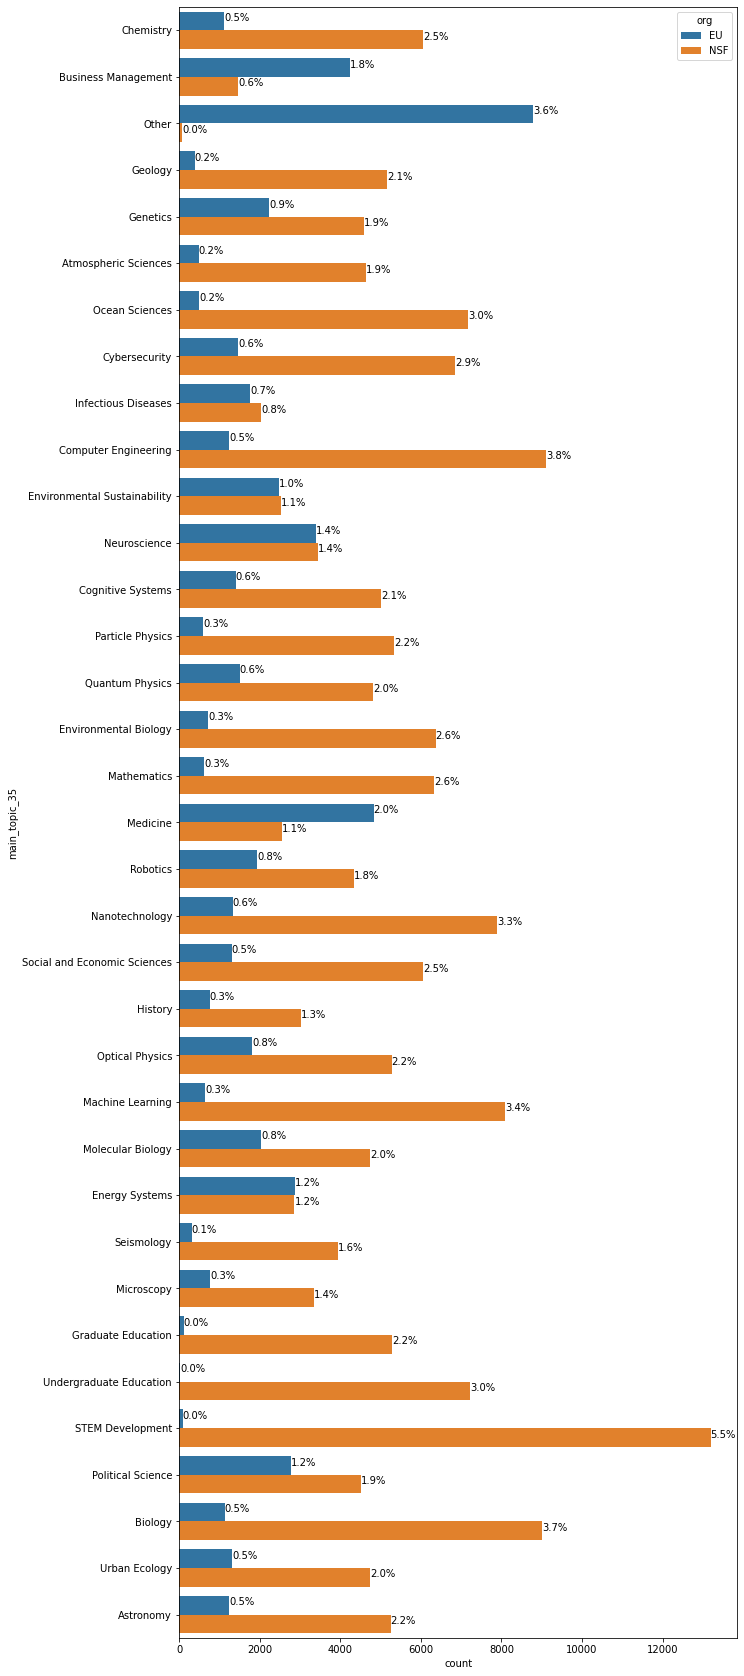

In [45]:
fig, axes = plt.subplots(1, 1, figsize=(10, 30), sharex=True)
#ids_order = [str(x) for x in list(range(45))]
#sns.countplot(data = corpusdata, y='main_topic_35', hue='org', order=tpc_descriptions)
#plt.show()


ax = sns.countplot(data = corpusdata, y='main_topic_35', hue='org', order=tpc_descriptions)

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(corpusdata))
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [91]:
cordis = pd.read_csv("data/cordis/cordis.csv",usecols=['id','totalCost','coordinatorCountry','startYear'])
nsf = pd.read_csv('data/nsf/nsf.csv',usecols=['AwardID','AwardAmount','CountryName','StateName','awardEffectiveYear'])

In [84]:
cordis.dtypes

id                     object
totalCost             float64
coordinatorCountry     object
startYear               int64
dtype: object

In [85]:
nsf.dtypes

AwardAmount      int64
AwardID        float64
StartDate       object
CountryName     object
StateName       object
dtype: object

In [92]:
nsf['AwardID'] = nsf['AwardID'].astype(str)
nsf.dtypes

AwardAmount            int64
AwardID               object
CountryName           object
StateName             object
awardEffectiveYear     int64
dtype: object

In [58]:
corpusdata.dtypes

id               object
abstract         object
org              object
lemmas           object
nlemmas           int64
nstopwords        int64
clean_lemmas     object
LDA_35           object
main_topic_35    object
dtype: object

In [93]:
corpusdata.org.value_counts()

NSF    182371
EU      58251
Name: org, dtype: int64

In [94]:
cordis_merge = pd.merge(corpusdata,cordis,on='id')
cordis_merge = cordis_merge[cordis_merge.org != 'NSF']
cordis_merge = cordis_merge.rename(columns = {'totalCost': 'budget', 'startYear': 'year','coordinatorCountry':'country'}, inplace = False)

In [95]:
nsf_merge = pd.merge(corpusdata,nsf,left_on='id',right_on='AwardID')
nsf_merge = nsf_merge.drop(columns='AwardID')
nsf_merge = nsf_merge.rename(columns = {'AwardAmount': 'budget', 'awardEffectiveYear': 'year','CountryName':'country','StateName':'state'}, inplace = False)

In [96]:
cordis_merge.dtypes

id                object
abstract          object
org               object
lemmas            object
nlemmas            int64
nstopwords         int64
clean_lemmas      object
LDA_35            object
main_topic_35     object
budget           float64
country           object
year               int64
dtype: object

In [97]:
nsf_merge.dtypes

id               object
abstract         object
org              object
lemmas           object
nlemmas           int64
nstopwords        int64
clean_lemmas     object
LDA_35           object
main_topic_35    object
budget            int64
country          object
state            object
year              int64
dtype: object

In [99]:
finaldf = pd.concat([cordis_merge,nsf_merge])

In [110]:
finaldf = finaldf[finaldf.year > 2000]

In [112]:
finaldf.to_csv('data/finaldf.csv',sep=';',index=False)

In [116]:
finaldf.shape

(134715, 13)